## imports

In [355]:
import requests
import pandas as pd
import numpy as np
import mysql.connector
import os
import importlib

import data.daily
import sqlalchemy
import matplotlib.pyplot as plt

from datetime import datetime, timedelta
from pandas_market_calendars import get_calendar

In [618]:
import data.polygon
importlib.reload(data.polygon)

<module 'data.polygon' from '/home/junlim/projects/volatility_trading/data/polygon.py'>

In [137]:
import data.daily
import algo.option_spread
importlib.reload(algo.option_spread)

<module 'algo.option_spread' from '/home/junlim/projects/volatility_trading/algo/option_spread.py'>

In [239]:
import util.tickers

In [138]:
import urllib.parse as urlparse
from urllib.parse import urlencode

In [532]:
import algo.expected_move
importlib.reload(algo.expected_move)

<module 'algo.expected_move' from '/home/junlim/projects/volatility_trading/algo/expected_move.py'>

In [142]:
polygon_api_key = os.getenv("QUANT_GALORE_POLYGON_API_KEY")
_POLYGON_V2_BASE_URL = "https://api.polygon.io/v2"
_POLYGON_V3_BASE_URL = "https://api.polygon.io/v3"

In [143]:
calendar = get_calendar("NYSE")
trading_dates = calendar.schedule(
    start_date = "2023-05-01", 
    end_date = "2024-07-02"
    #end_date = (datetime.today()-timedelta(days = 1))
).index.strftime("%Y-%m-%d").values

In [144]:
ticker_spy = "SPY"
ticker_spx = "I:SPX"
ticker_goog = "GOOG"
ticker_sbux = "SBUX"
ticker_vix1d = "I:VIX1D"
options_ticker = "SPX"

i = 2
date = trading_dates[i]
prior_day = trading_dates[i-1]

trade_list = []
times = []

In [145]:
df_spy_daily_history = pd.read_pickle('market_data/df_spy_daily_history.pkl')
df_spx_daily_history = pd.read_pickle('market_data/df_spx_daily_history.pkl')
df_goog_daily_history = pd.read_pickle('market_data/df_goog_daily_history.pkl')
df_sbux_daily_history = pd.read_pickle('market_data/df_sbux_daily_history.pkl')

df_spy_intraday_history = pd.read_pickle('market_data/df_spy_intraday_history.pkl')
df_vix1d_intraday_history = pd.read_pickle('market_data/df_vix1d_intraday_history.pkl')
df_spx_intraday_history = pd.read_pickle('market_data/df_spx_intraday_history.pkl')
df_goog_intraday_history = pd.read_pickle('market_data/df_goog_intraday_history.pkl')
df_sbux_intraday_history = pd.read_pickle('market_data/df_sbux_intraday_history.pkl')

df_spx_call_options_history = pd.read_pickle('market_data/df_spx_call_options_history.pkl')
df_spx_put_options_history = pd.read_pickle('market_data/df_spx_put_options_history.pkl')

In [146]:
df_goog_call_options_history = pd.read_pickle('market_data/df_goog_call_options_history.pkl')

In [721]:
df_spx_otm_call_options_spread_history = pd.read_pickle('market_data/df_spx_otm_call_options_spread_history.pkl')
df_spx_otm_put_options_spread_history = pd.read_pickle('market_data/df_spx_otm_put_options_spread_history.pkl')

In [722]:
df_spx_otm_call_options_spread_history[
  ['ask_price_market_o_s_call', 'bid_price_market_o_s_call', 'ask_price_market_o_l_call', 'bid_price_market_o_l_call'] +
  ['ask_price_market_c_s_call', 'bid_price_market_c_s_call', 'ask_price_market_c_l_call', 'bid_price_market_c_l_call'] + 
  ['market_o_spread', 'market_c_spread'] + ['pnl_midday', 'pnl_market_close', 'pnl']
]

,ask_price_market_o_s_call,bid_price_market_o_s_call,ask_price_market_o_l_call,bid_price_market_o_l_call,ask_price_market_c_s_call,bid_price_market_c_s_call,ask_price_market_c_l_call,bid_price_market_c_l_call,market_o_spread,market_c_spread,pnl_midday,pnl_market_close,pnl
date,,,,,,,,,,,,,
2023-05-02,2.70,2.60,1.75,1.65,0.05,0.00,0.05,0.0,0.85,0.05,0.75,0.80,0.80
2023-05-03,7.60,7.50,6.30,6.20,0.05,0.00,0.05,0.0,1.20,0.05,-0.50,1.15,1.15
2023-05-04,4.80,4.70,3.70,3.60,0.05,0.00,0.05,0.0,1.00,0.05,0.80,0.95,0.95
2023-05-05,4.20,4.00,3.10,2.95,10.90,10.00,6.00,5.5,0.90,5.40,-1.10,-4.50,-4.50
2023-05-08,2.50,2.45,1.65,1.60,0.05,0.00,0.05,0.0,0.80,0.05,0.60,0.75,0.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-26,3.20,3.10,2.15,2.10,3.30,2.95,0.65,0.6,0.95,2.70,-0.70,-1.75,-1.75
2024-06-27,2.45,2.35,1.55,1.50,0.05,0.00,0.05,0.0,0.80,0.05,0.40,0.75,0.75
2024-06-28,4.00,3.90,2.80,2.75,0.05,0.00,0.05,0.0,1.10,0.05,0.75,1.05,1.05


In [723]:
df_spx_otm_put_options_spread_history[
  ['ask_price_market_o_s_put', 'bid_price_market_o_s_put', 'ask_price_market_o_l_put', 'bid_price_market_o_l_put'] +
  ['ask_price_market_c_s_put', 'bid_price_market_c_s_put', 'ask_price_market_c_l_put', 'bid_price_market_c_l_put'] + 
  ['market_o_spread', 'market_c_spread'] + ['pnl_midday', 'pnl_market_close', 'pnl']
]

,ask_price_market_o_s_put,bid_price_market_o_s_put,ask_price_market_o_l_put,bid_price_market_o_l_put,ask_price_market_c_s_put,bid_price_market_c_s_put,ask_price_market_c_l_put,bid_price_market_c_l_put,market_o_spread,market_c_spread,pnl_midday,pnl_market_close,pnl
date,,,,,,,,,,,,,
2023-05-02,3.7,3.6,2.60,2.55,17.30,16.90,12.30,11.9,1.00,5.40,-4.500000e+00,-4.40,-4.40
2023-05-03,9.7,9.5,8.20,8.10,8.10,7.00,3.60,3.3,1.30,4.80,8.881784e-16,-3.50,-3.50
2023-05-04,6.6,6.4,5.50,5.30,1.65,1.45,0.50,0.4,0.90,1.25,-7.000000e-01,-0.35,-0.35
2023-05-05,5.6,5.4,4.60,4.40,0.05,0.00,0.05,0.0,0.80,0.05,6.000000e-01,0.75,0.75
2023-05-08,4.2,4.1,3.30,3.10,0.05,0.00,0.05,0.0,0.80,0.05,1.000000e-01,0.75,0.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-26,3.5,3.4,2.55,2.45,0.05,0.00,0.05,0.0,0.85,0.05,6.500000e-01,0.80,0.80
2024-06-27,4.3,4.1,3.30,3.10,0.40,0.35,0.15,0.1,0.80,0.30,-1.000000e-01,0.50,0.50
2024-06-28,5.8,5.7,4.50,4.40,14.70,13.50,11.00,8.9,1.20,5.80,-7.000000e-01,-4.60,-4.60


In [709]:
df_goog_otm_call_options_spread_history = pd.read_pickle('market_data/df_goog_otm_call_options_spread_history.pkl')
df_goog_otm_put_options_spread_history = pd.read_pickle('market_data/df_goog_otm_put_options_spread_history.pkl')
df_sbux_otm_call_options_spread_history = pd.read_pickle('market_data/df_sbux_otm_call_options_spread_history.pkl')
df_sbux_otm_put_options_spread_history = pd.read_pickle('market_data/df_sbux_otm_put_options_spread_history.pkl')

FileNotFoundError: [Errno 2] No such file or directory: 'market_data/df_goog_otm_call_options_spread_history.pkl'

In [437]:
df_goog_atm_vol_history = pd.read_pickle('market_data/df_GOOG_atm_vol_history.pkl')
df_sbux_atm_vol_history = pd.read_pickle('market_data/df_SBUX_atm_vol_history.pkl')

## debug

In [149]:
import algo.volatility
importlib.reload(algo.volatility)

<module 'algo.volatility' from '/home/junlim/projects/volatility_trading/algo/volatility.py'>

In [150]:
import data.polygon
import data.option_contracts
importlib.reload(data.option_contracts)

<module 'data.option_contracts' from '/home/junlim/projects/volatility_trading/data/option_contracts.py'>

In [613]:
df_options_history = df_spx_call_options_history.copy()
df_daily_expectation = df_spx_daily_expectation.copy()
df_otm_options_history = df_options_history.join(df_daily_expectation, on='date')
date_str, option_type = "2024-06-26", "call"

In [614]:
df_otm_options_history = df_otm_options_history[
    df_otm_options_history.strike_price > df_otm_options_history.upper_price
]    

In [622]:
df_otm_options_history

,cfi,contract_type,exercise_style,expiration_date,primary_exchange,shares_per_contract,strike_price,ticker,underlying_ticker,date,c_open,regime,expected_move,lower_price,upper_price
109,OCEICS,call,european,2023-05-02,XCBO,100.0,4170.0,O:SPXW230502C04170000,SPX,2023-05-02,4153.26,-1.0,0.0030,4140.80,4165.72
110,OCEICS,call,european,2023-05-02,XCBO,100.0,4175.0,O:SPXW230502C04175000,SPX,2023-05-02,4153.26,-1.0,0.0030,4140.80,4165.72
111,OCEICS,call,european,2023-05-02,XCBO,100.0,4180.0,O:SPXW230502C04180000,SPX,2023-05-02,4153.26,-1.0,0.0030,4140.80,4165.72
112,OCEICS,call,european,2023-05-02,XCBO,100.0,4185.0,O:SPXW230502C04185000,SPX,2023-05-02,4153.26,-1.0,0.0030,4140.80,4165.72
113,OCEICS,call,european,2023-05-02,XCBO,100.0,4190.0,O:SPXW230502C04190000,SPX,2023-05-02,4153.26,-1.0,0.0030,4140.80,4165.72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62522,OCEICS,call,european,2024-07-02,XCBO,100.0,6200.0,O:SPXW240702C06200000,SPX,2024-07-02,5465.69,1.0,0.0025,5452.03,5479.35
62523,OCEICS,call,european,2024-07-02,XCBO,100.0,6400.0,O:SPXW240702C06400000,SPX,2024-07-02,5465.69,1.0,0.0025,5452.03,5479.35
62524,OCEICS,call,european,2024-07-02,XCBO,100.0,6600.0,O:SPXW240702C06600000,SPX,2024-07-02,5465.69,1.0,0.0025,5452.03,5479.35
62525,OCEICS,call,european,2024-07-02,XCBO,100.0,6800.0,O:SPXW240702C06800000,SPX,2024-07-02,5465.69,1.0,0.0025,5452.03,5479.35


In [620]:
market_2_minutes_timestamp, market_5_minutes_timestamp = (1682947920000000000, 1682948100000000000)

In [624]:
data.polygon.polygon_url_to_dataframe(data.polygon.get_polygon_quotes_url("O:SPXW230502C04170000", market_2_minutes_timestamp, market_5_minutes_timestamp))

,ask_exchange,ask_price,ask_size,bid_exchange,bid_price,bid_size,sequence_number,sip_timestamp
0,302,13.0,16,302,12.8,8,23688492,1682947920011984128
1,302,13.0,17,302,12.8,8,23688557,1682947920012370176
2,302,13.0,16,302,12.8,8,23688673,1682947920013312256
3,302,13.0,12,302,12.8,8,23689534,1682947920023426304
4,302,13.0,12,302,12.7,45,23690750,1682947920028313600
...,...,...,...,...,...,...,...,...
7007,302,13.7,16,302,13.5,63,56621398,1682948099648228864
7008,302,13.7,16,302,13.5,72,56642182,1682948099806616832
7009,302,13.7,16,302,13.5,68,56643427,1682948099815082496
7010,302,13.7,16,302,13.5,51,56645673,1682948099825346560


In [153]:
import algo.option_spread
importlib.reload(algo.option_spread)

<module 'algo.option_spread' from '/home/junlim/projects/volatility_trading/algo/option_spread.py'>

In [154]:
algo.option_spread.get_df_otm_options_spread_history(df_daily_expectation, df_options_history, "put", ["2023-06-14"], tolerance_days=5)

,c_market_o_s_put,ticker_market_o_s_put,c_market_o_l_put,ticker_market_o_l_put,market_o_spread,c_market_c_s_put,c_market_c_l_put,market_c_spread,pnl
t,,,,,,,,,
2023-06-14,2.18,O:GOOG230616C00121000,3.13,O:GOOG230616C00120000,-0.95,3.25,4.0,-0.75,-0.2


In [96]:
algo.option_spread.get_df_otm_options_spread("2024-05-21", df_otm_options_history, "put", tolerance_days=5)

In [97]:
algo.option_spread.get_df_otm_options_spread_history(df_daily_expectation, df_options_history, "put", ["2024-05-20", "2024-05-21", "2024-05-22", "2024-05-23"], tolerance_days=5)

,c_market_o_s_put,ticker_market_o_s_put,c_market_o_l_put,ticker_market_o_l_put,market_o_spread,c_market_c_s_put,c_market_c_l_put,market_c_spread,pnl
t,,,,,,,,,
2024-05-20,4.40,O:GOOG240524C00175000,6.54,O:GOOG240524C00172500,-2.14,4.21,6.35,-2.14,0.00
2024-05-21,3.55,O:GOOG240524C00175000,5.65,O:GOOG240524C00172500,-2.10,5.10,7.60,-2.50,0.40
2024-05-22,3.14,O:GOOG240524C00175000,5.65,O:GOOG240524C00172500,-2.51,3.50,5.25,-1.75,-0.76
2024-05-23,4.35,O:GOOG240524C00175000,7.10,O:GOOG240524C00172500,-2.75,0.97,2.79,-1.82,-0.93


In [103]:
df_goog_otm_call_options_spread_history = algo.option_spread.get_df_otm_options_spread_history(df_daily_expectation, df_options_history, "call", trading_dates, tolerance_days=5)

In [104]:
df_goog_otm_put_options_spread_history = algo.option_spread.get_df_otm_options_spread_history(df_daily_expectation, df_options_history, "put", trading_dates, tolerance_days=5)

In [105]:
df_goog_otm_call_options_spread_history.to_pickle('market_data/df_goog_otm_call_options_spread_history.pkl')
df_goog_otm_put_options_spread_history.to_pickle('market_data/df_goog_otm_put_options_spread_history.pkl')

In [155]:
df_goog_daily_expectation[df_goog_daily_expectation.index == "2023-05-26"]

,c_market_open,regime,expected_move,lower_price,upper_price
t,,,,,
2023-05-26,123.79,1,NaN,NaN,NaN


In [106]:
df_goog_market_open_close_put_spread_history = df_goog_market_open_close_history.join(df_goog_otm_put_options_spread_history).join(df_goog_daily_expectation[['regime', 'expected_move', 'lower_price', 'upper_price']])

In [156]:
df_goog_market_open_close_put_spread_history[
    (df_goog_market_open_close_put_spread_history.regime > 0) &
    (df_goog_market_open_close_put_spread_history.pnl < -0.05)
].sort_values('pnl').head()

,c_open,c_close,actual_change,c_market_o_s_put,ticker_market_o_s_put,c_market_o_l_put,ticker_market_o_l_put,market_o_spread,c_market_c_s_put,c_market_c_l_put,market_c_spread,pnl,regime,expected_move,lower_price,upper_price
t,,,,,,,,,,,,,,,,
2023-08-14,129.8800,132.1800,2.3000,2.87,O:GOOG230818C00128000,4.30,O:GOOG230818C00127000,-1.43,4.18,4.35,-0.17,-1.26,1,0.0076,128.89,130.87
2023-10-24,139.0700,131.8100,-7.2600,5.45,O:GOOG231027C00136000,6.57,O:GOOG231027C00135000,-1.12,6.40,6.58,-0.18,-0.94,1,0.0203,136.25,141.89
2024-05-23,179.5252,175.4800,-4.0452,4.35,O:GOOG240524C00175000,7.10,O:GOOG240524C00172500,-2.75,0.97,2.79,-1.82,-0.93,1,0.0160,176.65,182.40
2024-04-04,154.8200,150.7100,-4.1100,2.66,O:GOOG240405C00152500,5.00,O:GOOG240405C00150000,-2.34,0.88,2.40,-1.52,-0.82,1,0.0136,152.71,156.93
2024-01-03,139.2300,140.4793,1.2493,2.06,O:GOOG240105C00138000,3.10,O:GOOG240105C00137000,-1.04,3.15,3.38,-0.23,-0.81,1,0.0077,138.16,140.30


In [114]:
df_goog_market_open_close_put_spread_history[
    (df_goog_market_open_close_put_spread_history.regime > 0) &
    (df_goog_market_open_close_put_spread_history.c_close > df_goog_market_open_close_put_spread_history.c_open)
].dropna().sort_values('pnl')

,c_open,c_close,actual_change,c_market_o_s_put,ticker_market_o_s_put,c_market_o_l_put,ticker_market_o_l_put,market_o_spread,c_market_c_s_put,c_market_c_l_put,market_c_spread,pnl,regime,expected_move,lower_price,upper_price
t,,,,,,,,,,,,,,,,
2023-08-14,129.88,132.1800,2.3000,2.87,O:GOOG230818C00128000,4.30,O:GOOG230818C00127000,-1.43,4.18,4.35,-0.17,-1.26,1,0.0076,128.89,130.87
2024-01-03,139.23,140.4793,1.2493,2.06,O:GOOG240105C00138000,3.10,O:GOOG240105C00137000,-1.04,3.15,3.38,-0.23,-0.81,1,0.0077,138.16,140.30
2023-05-30,123.89,125.0500,1.1600,3.00,O:GOOG230602C00122000,4.20,O:GOOG230602C00121000,-1.20,3.44,3.85,-0.41,-0.79,1,0.0089,122.79,124.99
2024-03-27,151.65,151.7500,0.1000,1.77,O:GOOG240328C00150000,3.20,O:GOOG240328C00149000,-1.43,2.04,2.78,-0.74,-0.69,1,0.0061,150.72,152.58
2023-09-07,134.13,136.3700,2.2400,2.45,O:GOOG230908C00132000,4.33,O:GOOG230908C00131000,-1.88,4.30,5.55,-1.25,-0.63,1,0.0117,132.56,135.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-08,132.94,133.1100,0.1700,1.69,O:GOOG231110C00132000,2.01,O:GOOG231110C00131000,-0.32,1.70,2.56,-0.86,0.54,1,0.0056,132.20,133.68
2024-05-29,177.18,177.3500,0.1700,2.85,O:GOOG240531C00175000,4.46,O:GOOG240531C00172500,-1.61,2.73,4.91,-2.18,0.57,1,0.0064,176.05,178.31
2024-03-25,149.87,151.0600,1.1900,2.80,O:GOOG240328C00148000,3.10,O:GOOG240328C00147000,-0.30,3.45,4.35,-0.90,0.60,1,0.0069,148.84,150.90


<Axes: xlabel='t'>

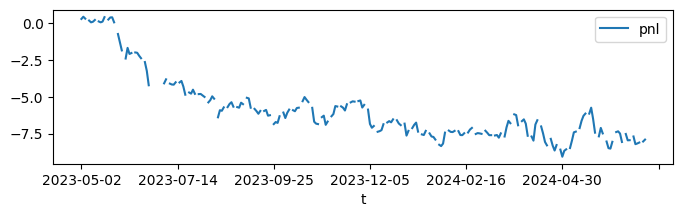

In [157]:
df_goog_market_open_close_put_spread_history[["pnl"]].cumsum().plot(figsize=(8,2))

## logic

In [481]:
df_spy = df_spy_daily_history[["c"]].copy()
df_spy["1_mo_avg"] = df_spy["c"].rolling(window=20).mean()
df_spy["3_mo_avg"] = df_spy["c"].rolling(window=60).mean()
df_spy['regime'] = df_spy.apply(lambda row: 1 if (row['c'] > row['1_mo_avg']) else -1, axis=1)

In [499]:
df_spx_market_open_close_history = data.daily.load_df_market_open_close_history(util.tickers.ticker_spx)
df_vix1d_market_open_close_history = data.daily.load_df_market_open_close_history(util.tickers.ticker_vix1d)

In [547]:
df_spx_daily_expectation = algo.expected_move.get_df_daily_expectation(df_spx_market_open_close_history[["c_open"]], df_spy.regime, df_vix1d_market_open_close_history.c_open / 100, 0.5)

In [548]:
df_spx_daily_expectation_actual = df_spx_daily_expectation.join(df_spx_market_open_close_history["actual_change"])
df_spx_daily_expectation_actual["expected_change_size"] = df_spx_daily_expectation_actual.upper_price - df_spx_daily_expectation_actual.lower_price

In [549]:
df_spx_daily_expectation_actual

,c_open,regime,expected_move,lower_price,upper_price,actual_change,expected_change_size
t,,,,,,,
2023-05-01,4168.46,1,0.0029,4156.37,4180.55,-0.59,24.18
2023-05-02,4153.26,-1,0.0030,4140.80,4165.72,-33.68,24.92
2023-05-03,4125.70,-1,0.0060,4100.95,4150.45,-34.95,49.50
2023-05-04,4081.20,-1,0.0047,4062.02,4100.38,-19.98,38.36
2023-05-05,4104.23,1,0.0041,4087.40,4121.06,32.02,33.66
...,...,...,...,...,...,...,...
2024-06-26,5457.73,1,0.0024,5444.63,5470.83,20.17,26.20
2024-06-27,5483.08,1,0.0024,5469.92,5496.24,-0.21,26.32
2024-06-28,5496.61,1,0.0028,5481.22,5512.00,-36.13,30.78


/tmp/ipykernel_51020/3788827896.py:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 50], [0, 50], 'k-', color = 'r')


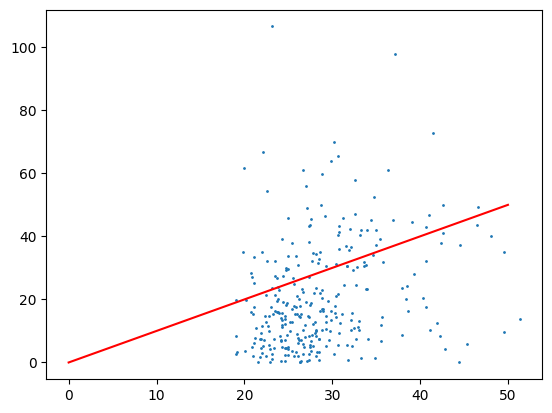

In [553]:
plt.figure()
plt.scatter(df_spx_daily_expectation_actual[["expected_change_size"]], df_spx_daily_expectation_actual[["actual_change"]].abs(), s=1)
plt.plot([0, 50], [0, 50], 'k-', color = 'r')

/tmp/ipykernel_51020/3531173125.py:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot([-50, 50], [-50, 50], 'k-', color = 'r')


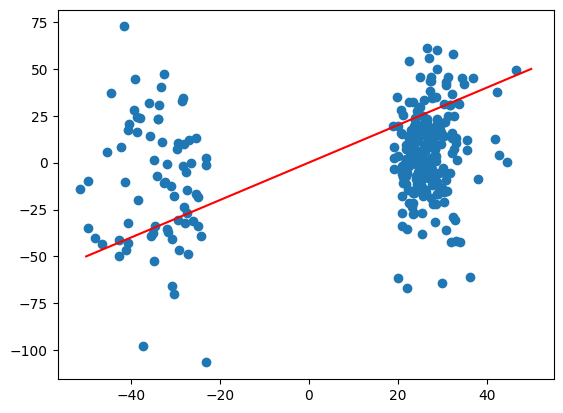

In [551]:
plt.scatter(df_spx_daily_expectation_actual["regime"] * df_spx_daily_expectation_actual["expected_change_size"], df_spx_daily_expectation_actual[["actual_change"]])
plt.plot([-50, 50], [-50, 50], 'k-', color = 'r')

## goog logic

In [40]:
df_goog = df_goog_daily_history[["c"]].copy()
df_goog["1_mo_avg"] = df_goog["c"].rolling(window=20).mean()
df_goog["3_mo_avg"] = df_goog["c"].rolling(window=60).mean()
df_goog['regime'] = df_goog.apply(lambda row: 1 if (row['c'] > row['1_mo_avg']) else -1, axis=1)

In [513]:
df_goog_market_open_close_history = data.daily.load_df_market_open_close_history(util.tickers.ticker_goog)

In [564]:
df_goog_daily_expectation = algo.expected_move.get_df_daily_expectation(
    df_goog_market_open_close_history[["c_open"]], df_goog.regime, 
    (df_goog_atm_vol_history.atm_call_vol_market_open + df_goog_atm_vol_history.atm_put_vol_market_open) / 2, 
    1.)

In [565]:
df_goog_daily_expectation_actual = df_goog_daily_expectation.join(df_goog_market_open_close_history["actual_change"])
df_goog_daily_expectation_actual["expected_change_size"] = (df_goog_daily_expectation_actual.upper_price - df_goog_daily_expectation_actual.lower_price) / 2.

/tmp/ipykernel_51020/998933240.py:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 10], [0, 10], 'k-', color = 'r')


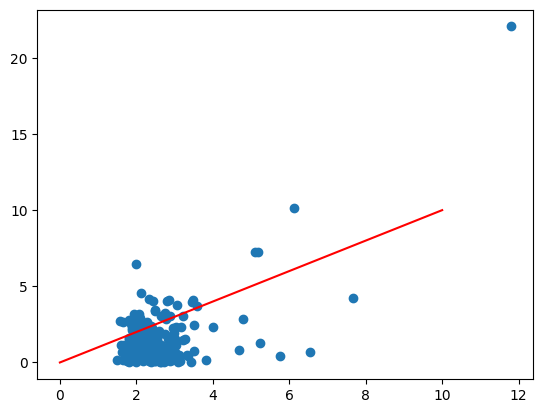

In [566]:
plt.scatter(df_goog_daily_expectation_actual[["expected_change_size"]], df_goog_daily_expectation_actual[["actual_change"]].abs())
plt.plot([0, 10], [0, 10], 'k-', color = 'r')

/tmp/ipykernel_51020/2614324189.py:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot([-10, 10], [-10, 10], 'k-', color = 'r')


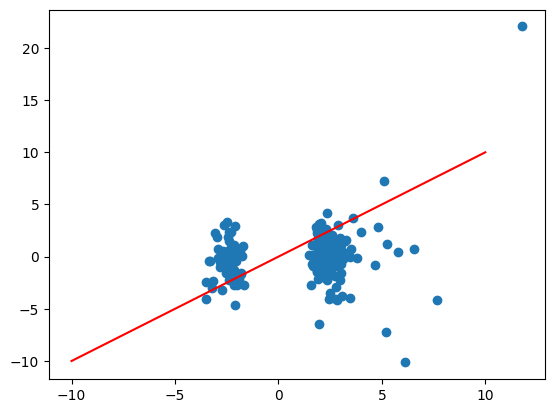

In [567]:
plt.scatter(df_goog_daily_expectation_actual["regime"] * df_goog_daily_expectation_actual["expected_change_size"], df_goog_daily_expectation_actual[["actual_change"]])
plt.plot([-10, 10], [-10, 10], 'k-', color = 'r')

/tmp/ipykernel_51020/2087232855.py:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot([-10, 10], [-10, 10], 'k-', color = 'r')
/tmp/ipykernel_51020/2087232855.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot([-10, 10], [10, -10], 'k-', color = 'r')


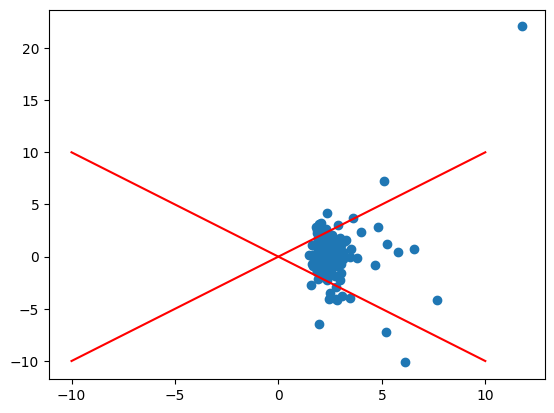

In [568]:
df_goog_daily_expectation_actual_regime_1 = df_goog_daily_expectation_actual[df_goog_daily_expectation_actual.regime > 0]
plt.scatter(df_goog_daily_expectation_actual_regime_1["regime"] * df_goog_daily_expectation_actual_regime_1["expected_change_size"], df_goog_daily_expectation_actual_regime_1[["actual_change"]])
plt.plot([-10, 10], [-10, 10], 'k-', color = 'r')
plt.plot([-10, 10], [10, -10], 'k-', color = 'r')

## call put balance

In [438]:
import algo.call_put_balance.research
importlib.reload(algo.call_put_balance.research)
importlib.reload(data.daily)
importlib.reload(data.intraday)
importlib.reload(algo.volatility)
importlib.reload(util.tickers)

<module 'util.tickers' from '/home/junlim/projects/volatility_trading/util/tickers.py'>

In [590]:
df_goog = df_goog_daily_history[["c"]].copy()
df_goog["1_mo_avg"] = df_goog["c"].rolling(window=20).mean()
df_goog["3_mo_avg"] = df_goog["c"].rolling(window=60).mean()
df_goog['regime'] = df_goog.apply(lambda row: 1 if (row['c'] > row['1_mo_avg']) else -1, axis=1)

In [439]:
df_goog_market_open_close_history = data.daily.load_df_market_open_close_history(ticker_goog)

In [457]:
high_vol_threshold=0.3
low_vol_threshold=0.3

In [591]:
df_goog_atm_vol_actual_change = df_goog_market_open_close_history.join(df_goog_atm_vol_history).join(df_goog)

In [458]:
df_high_call_vol_actual_change = pd.concat([algo.call_put_balance.research.get_df_high_call_vol_actual_change(ticker, high_vol_threshold=high_vol_threshold, low_vol_threshold=low_vol_threshold) for ticker in util.tickers.get_stock_tickers()[:]])
# remove outlier
df_high_call_vol_actual_change = df_high_call_vol_actual_change[df_high_call_vol_actual_change.atm_call_vol_market_open < 10] 

In [443]:
df_high_put_vol_actual_change = pd.concat([algo.call_put_balance.research.get_df_high_put_vol_actual_change(ticker, high_vol_threshold=high_vol_threshold, low_vol_threshold=low_vol_threshold) for ticker in util.tickers.get_stock_tickers()])

In [574]:
df_high_call_vol_actual_change.groupby('ticker').sum()[['actual_return']].sort_values('actual_return')

,actual_return
ticker,
ORCL,-0.059368
JNJ,-0.035379
AAPL,-0.030425
SBUX,-0.022071
MSFT,-0.009476
KO,-0.008235
XOM,-0.006062
MA,-0.000566
MRK,0.000768


In [575]:
df_high_put_vol_actual_change.groupby('ticker').sum()[['actual_return']].sort_values('actual_return')

,actual_return
ticker,
MRK,-0.042597
XOM,-0.028680
ORCL,-0.027019
PG,-0.026098
V,-0.009723
TSM,-0.009655
CVX,-0.005911
TM,-0.004234
UNH,-0.000963


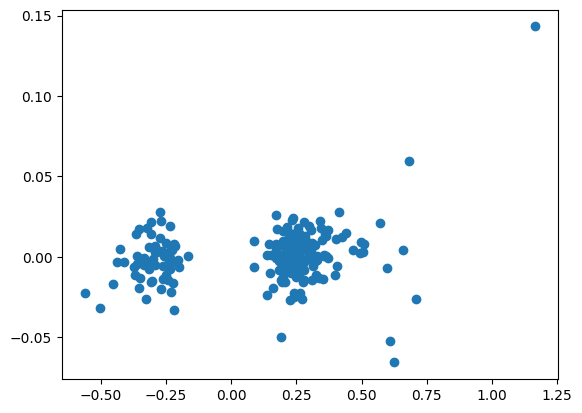

In [594]:
plt.scatter(df_goog_atm_vol_actual_change["atm_call_vol_market_open"] * df_goog_atm_vol_actual_change["regime"], df_goog_atm_vol_actual_change[["actual_return"]])

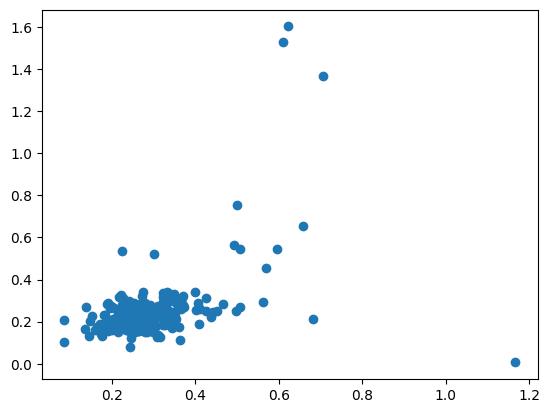

In [586]:
plt.scatter(df_goog_atm_vol_actual_change[["atm_call_vol_market_open"]], df_goog_atm_vol_actual_change[["atm_call_vol_market_close"]])

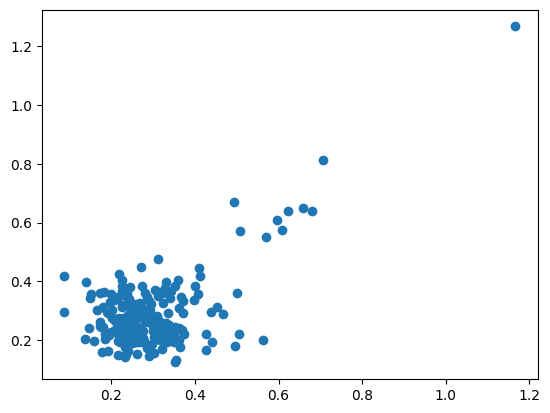

In [587]:
plt.scatter(df_goog_atm_vol_actual_change[["atm_call_vol_market_open"]], df_goog_atm_vol_actual_change[["atm_put_vol_market_open"]])

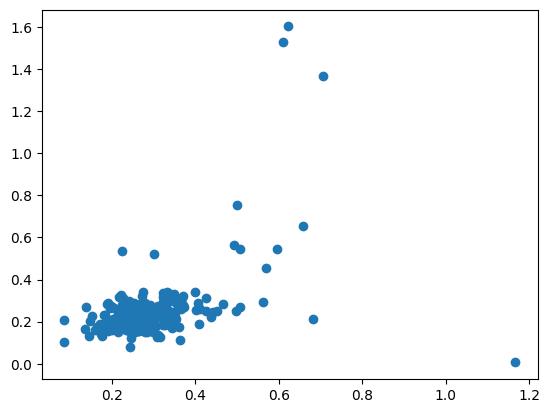

In [583]:
plt.scatter(df_goog_atm_vol_actual_change[["atm_call_vol_market_open"]], df_goog_atm_vol_actual_change[["atm_call_vol_market_close"]])

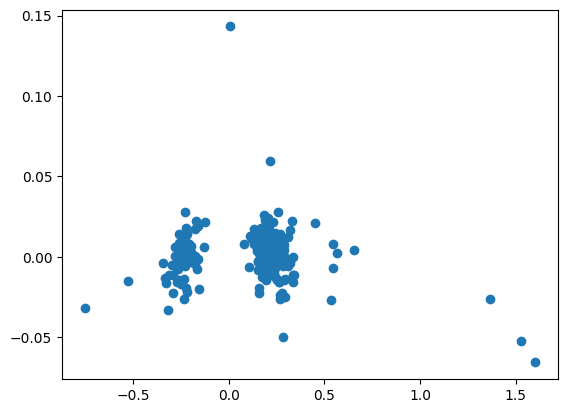

In [595]:
plt.scatter(df_goog_atm_vol_actual_change["atm_call_vol_market_close"] * df_goog_atm_vol_actual_change["regime"], df_goog_atm_vol_actual_change[["actual_return"]])

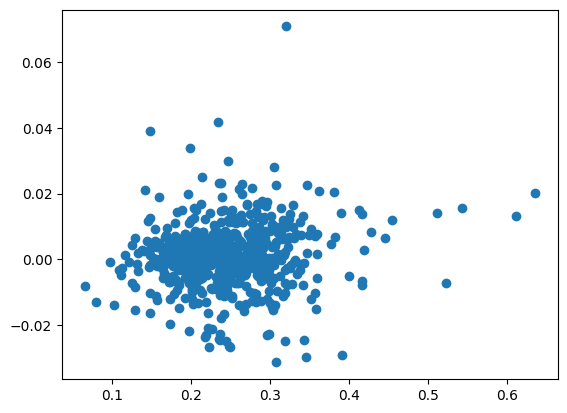

In [572]:
plt.scatter(df_high_call_vol_actual_change[["atm_call_vol_market_close"]], df_high_call_vol_actual_change[["return_nextday_open"]])

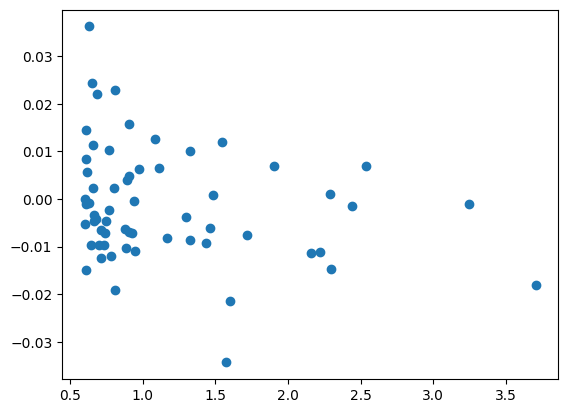

In [467]:
plt.scatter(df_high_put_vol_actual_change[["atm_put_vol_market_open"]], df_high_put_vol_actual_change[["actual_return"]])

<Axes: xlabel='date'>

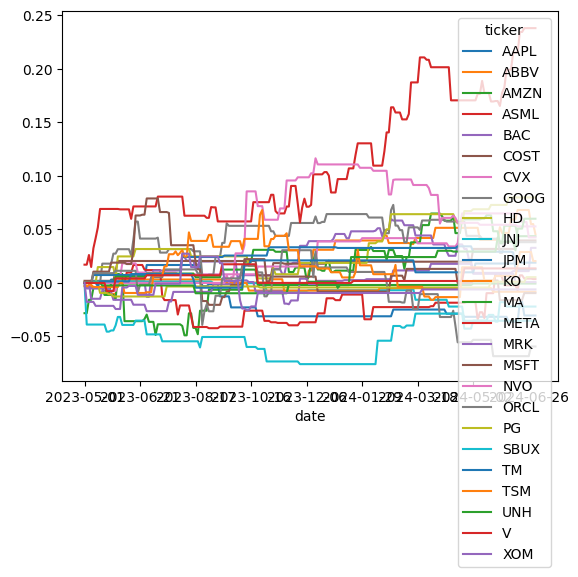

In [573]:
df_high_call_vol_actual_change.sort_index().pivot(columns='ticker', values='actual_return').fillna(0).cumsum().plot()

<Axes: xlabel='date'>

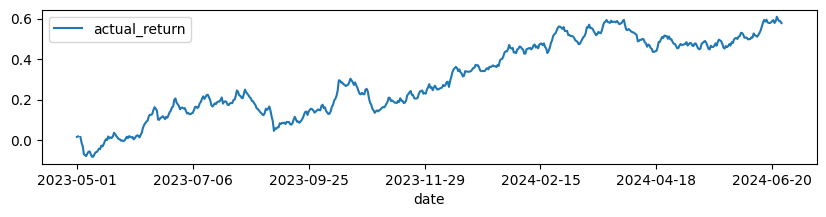

In [469]:
df_high_call_vol_actual_change.sort_index()[['actual_return']].cumsum().plot(figsize=(10,2))

<Axes: xlabel='date'>

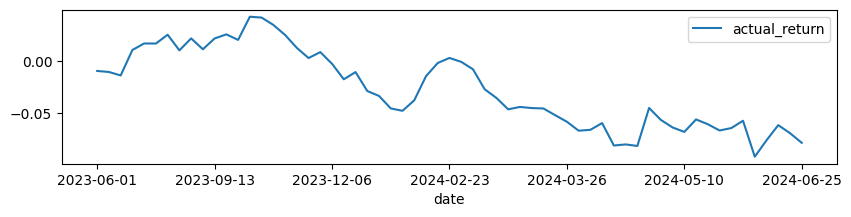

In [470]:
df_high_put_vol_actual_change.sort_index()[['actual_return']].cumsum().plot(figsize=(10,2))

array([[<Axes: title={'center': 'actual_return'}>]], dtype=object)

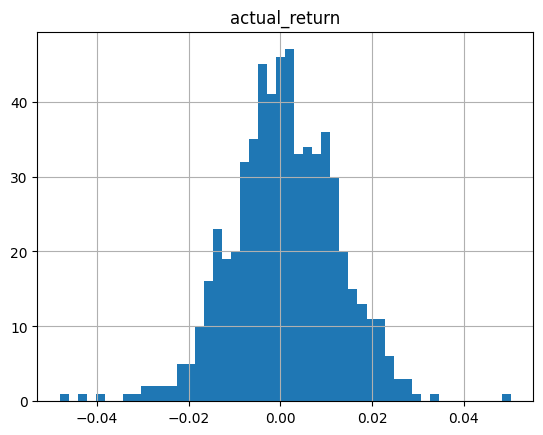

In [471]:
df_high_call_vol_actual_change[['actual_return']].hist(bins=50)

array([[<Axes: title={'center': 'actual_return'}>]], dtype=object)

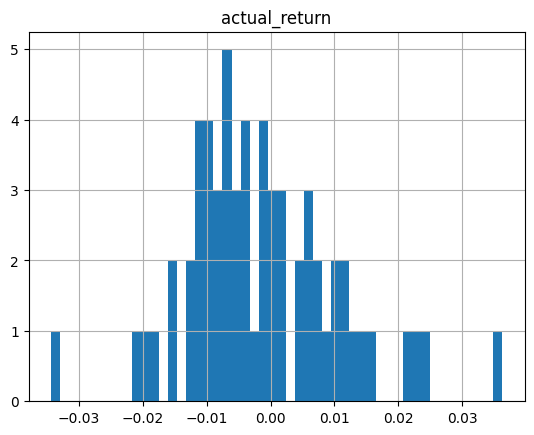

In [472]:
df_high_put_vol_actual_change[['actual_return']].hist(bins=50)

### goog

In [474]:
df_goog_atm_vol_history['atm_vol_market_open'] = (df_goog_atm_vol_history['atm_call_vol_market_open'] + df_goog_atm_vol_history['atm_put_vol_market_open']) / 2.0

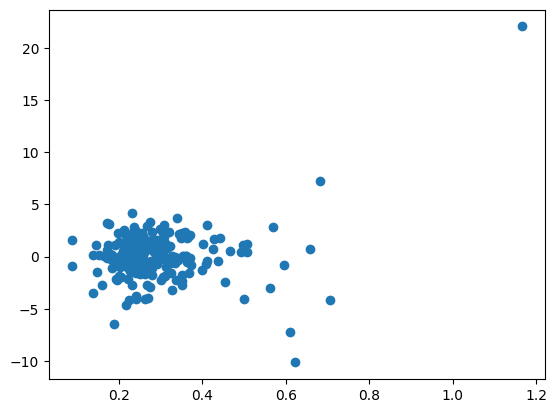

In [475]:
df_goog_atm_call_vol_actual_change = df_goog_atm_vol_history[['atm_call_vol_market_open']].join(df_goog_market_open_close_history[['actual_change']])
plt.scatter(df_goog_atm_call_vol_actual_change[["atm_call_vol_market_open"]], df_goog_atm_call_vol_actual_change[["actual_change"]])
#plt.plot([-1, 1], [-1, 1], 'k-', color = 'r')

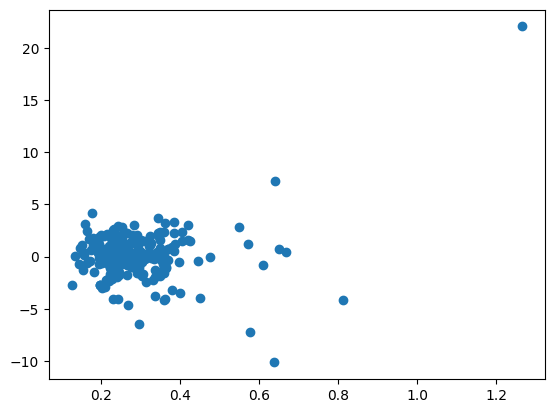

In [476]:
df_goog_atm_put_vol_actual_change = df_goog_atm_vol_history[['atm_put_vol_market_open']].join(df_goog_market_open_close_history[['actual_change']])
plt.scatter(df_goog_atm_put_vol_actual_change[["atm_put_vol_market_open"]], df_goog_atm_put_vol_actual_change[["actual_change"]])
#plt.plot([-1, 1], [-1, 1], 'k-', color = 'r')

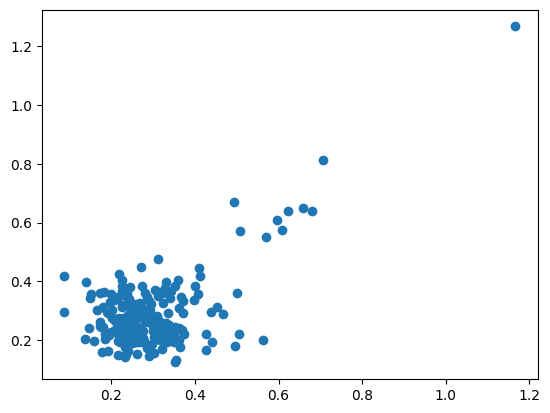

In [477]:
plt.scatter(df_goog_atm_vol_history[["atm_call_vol_market_open"]], df_goog_atm_vol_history[["atm_put_vol_market_open"]])

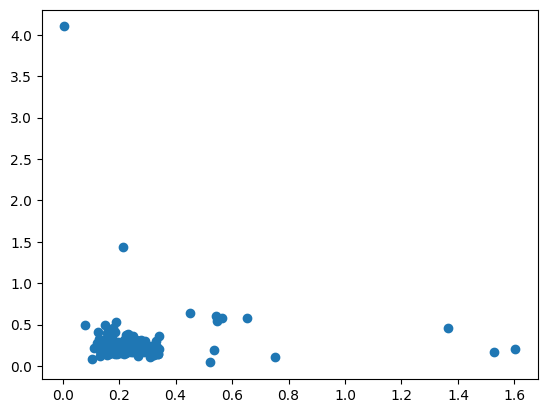

In [478]:
plt.scatter(df_goog_atm_vol_history[["atm_call_vol_market_close"]], df_goog_atm_vol_history[["atm_put_vol_market_close"]])

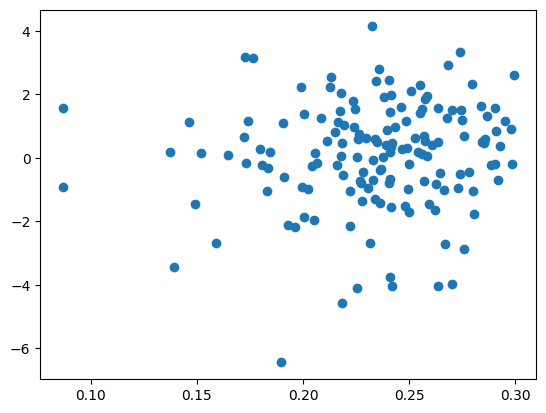

In [479]:
vol_threshold = 0.3
df_goog_small_atm_call_vol_history = df_goog_atm_vol_history[
    (df_goog_atm_vol_history.atm_call_vol_market_open < vol_threshold)
]
df_goog_small_atm_call_vol_atm_actual_change = df_goog_small_atm_call_vol_history[['atm_call_vol_market_open']].join(df_goog_market_open_close_history[['actual_change']])
plt.scatter(df_goog_small_atm_call_vol_atm_actual_change[["atm_call_vol_market_open"]], df_goog_small_atm_call_vol_atm_actual_change[["actual_change"]])

In [480]:
df_goog_small_atm_call_vol_atm_actual_change

,atm_call_vol_market_open,actual_change
date,,
2023-05-02,0.241587,-1.5500
2023-05-03,0.237472,0.0300
2023-05-08,0.279653,2.3400
2023-05-15,0.227160,-0.7950
2023-05-16,0.235815,2.8100
...,...,...
2024-06-25,0.232630,4.1399
2024-06-26,0.248880,0.3200
2024-06-27,0.256910,0.7000


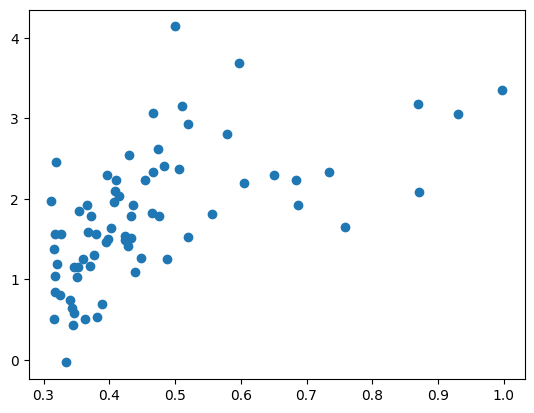

In [368]:
vol_threshold = 0.3
df_goog_large_atm_call_vol_history = df_goog_atm_vol_history[
    (df_goog_atm_vol_history.atm_call_vol_market_open > vol_threshold) &
    (df_goog_atm_vol_history.atm_put_vol_market_open < vol_threshold)
]
df_goog_large_atm_call_vol_atm_actual_change = df_goog_large_atm_call_vol_history[['atm_call_vol_market_open']].join(df_goog_market_open_close_history[['actual_change', 'actual_return']])
plt.scatter(df_goog_large_atm_call_vol_atm_actual_change[["atm_call_vol_market_open"]], df_goog_large_atm_call_vol_atm_actual_change[["actual_change"]])

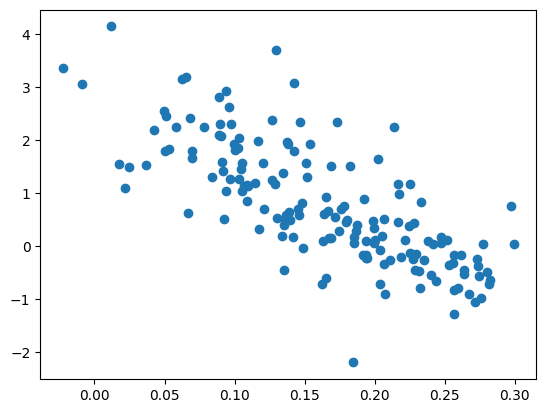

In [369]:
vol_threshold = 0.3
df_goog_small_atm_put_vol_history = df_goog_atm_vol_history[
    (df_goog_atm_vol_history.atm_put_vol_market_open < vol_threshold)
]
df_goog_small_atm_put_vol_atm_actual_change = df_goog_small_atm_put_vol_history[['atm_put_vol_market_open']].join(df_goog_market_open_close_history[['actual_change']])
plt.scatter(df_goog_small_atm_put_vol_atm_actual_change[["atm_put_vol_market_open"]], df_goog_small_atm_put_vol_atm_actual_change[["actual_change"]])

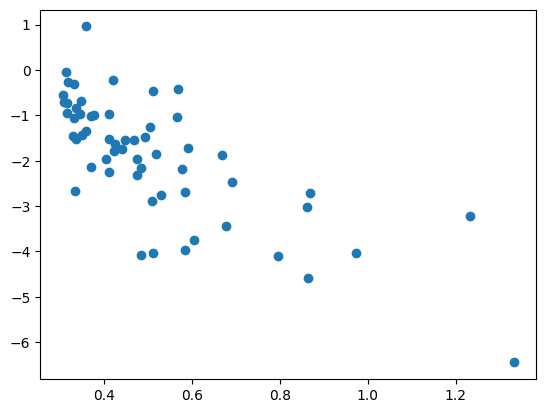

In [370]:
vol_threshold = 0.3
df_goog_large_atm_put_vol_history = df_goog_atm_vol_history[
    (df_goog_atm_vol_history.atm_call_vol_market_open < vol_threshold) &
    (df_goog_atm_vol_history.atm_put_vol_market_open > vol_threshold)
]
df_goog_large_atm_put_vol_atm_actual_change = df_goog_large_atm_put_vol_history[['atm_call_vol_market_open', 'atm_put_vol_market_open']].join(df_goog_market_open_close_history[['actual_change', 'actual_return']])
plt.scatter(df_goog_large_atm_put_vol_atm_actual_change[["atm_put_vol_market_open"]], df_goog_large_atm_put_vol_atm_actual_change[["actual_change"]])

<Axes: xlabel='date'>

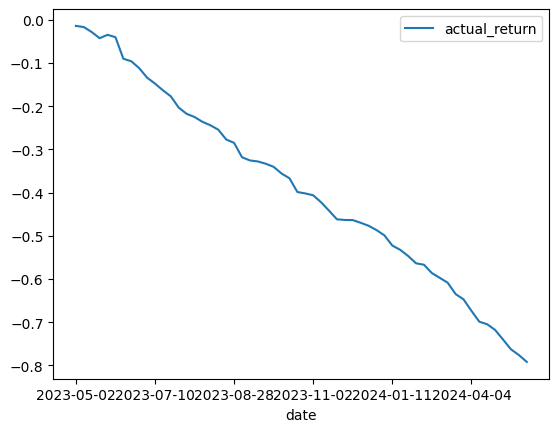

In [169]:
df_goog_large_atm_put_vol_atm_actual_change[['actual_return']].cumsum().plot()

/tmp/ipykernel_9519/2116876228.py:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot([-1, 1], [-1, 1], 'k-', color = 'r')


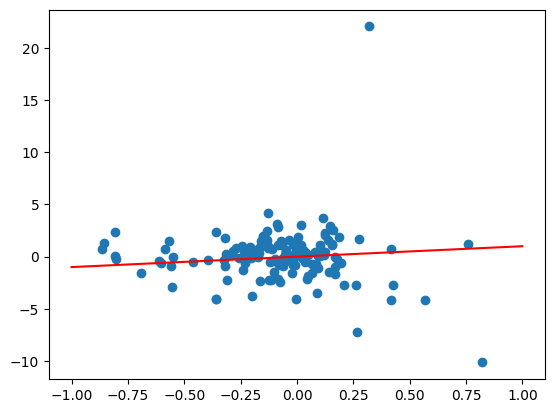

In [233]:
rolling_size = 90
df_goog_atm_vol_min_max_history = df_goog_atm_vol_history.join(df_goog_atm_vol_history[['atm_vol']].rolling(rolling_size).min().join(df_goog_atm_vol_history[['atm_vol']].rolling(rolling_size).max(), lsuffix="_min", rsuffix="_max"))
df_goog_atm_vol_min_max_history['atm_vol_level'] = (df_goog_atm_vol_min_max_history.atm_vol - df_goog_atm_vol_min_max_history.atm_vol_min) / (df_goog_atm_vol_min_max_history.atm_vol_max - df_goog_atm_vol_min_max_history.atm_vol_min)
df_vix1d_market_open_min_max_history = df_vix1d_market_open_history.join(df_vix1d_market_open_history.rolling(rolling_size).min().join(df_vix1d_market_open_history.rolling(rolling_size).max(), lsuffix="_min", rsuffix="_max"))
df_vix1d_market_open_min_max_history['vix_level'] = (df_vix1d_market_open_min_max_history.c - df_vix1d_market_open_min_max_history.c_min) / (df_vix1d_market_open_min_max_history.c_max - df_vix1d_market_open_min_max_history.c_min)

df_vix1d_goog_vol_min_max_history = df_goog_atm_vol_min_max_history[['atm_vol_level']].join(df_vix1d_market_open_min_max_history[['vix_level']])
df_vix1d_goog_vol_min_max_history['atm_minus_vix_level'] = df_vix1d_goog_vol_min_max_history.atm_vol_level - df_vix1d_goog_vol_min_max_history.vix_level
df_vix1d_goog_vol_min_max_actual_history = df_vix1d_goog_vol_min_max_history.join(df_goog_market_open_close_history["actual_change"])

plt.scatter(df_vix1d_goog_vol_min_max_actual_history[["atm_minus_vix_level"]], df_vix1d_goog_vol_min_max_actual_history[["actual_change"]])
plt.plot([-1, 1], [-1, 1], 'k-', color = 'r')

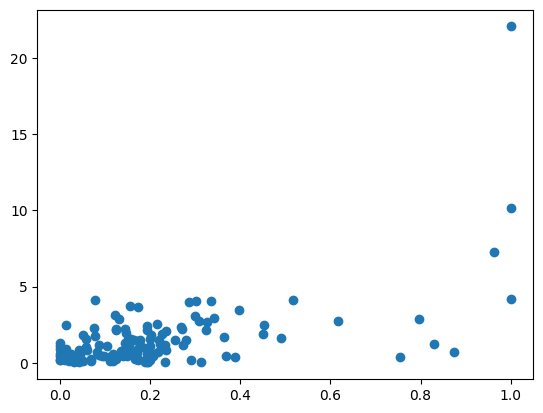

In [234]:
df_goog_atm_vol_level_actual_change = df_goog_atm_vol_min_max_history[['atm_vol_level']].join(df_goog_market_open_close_history[['actual_change']])
plt.scatter(df_goog_atm_vol_level_actual_change[["atm_vol_level"]], df_goog_atm_vol_level_actual_change[["actual_change"]].abs())
#plt.plot([-1, 1], [-1, 1], 'k-', color = 'r')

### sbux

In [371]:
df_sbux_atm_call_vol_actual_change = df_sbux_atm_vol_history[['atm_call_vol_market_open']].join(df_sbux_market_open_close_history[['actual_change']])
plt.scatter(df_sbux_atm_call_vol_actual_change[["atm_call_vol_market_open"]], df_sbux_atm_call_vol_actual_change[["actual_change"]])
#plt.plot([-1, 1], [-1, 1], 'k-', color = 'r')

NameError: name 'df_sbux_market_open_close_history' is not defined

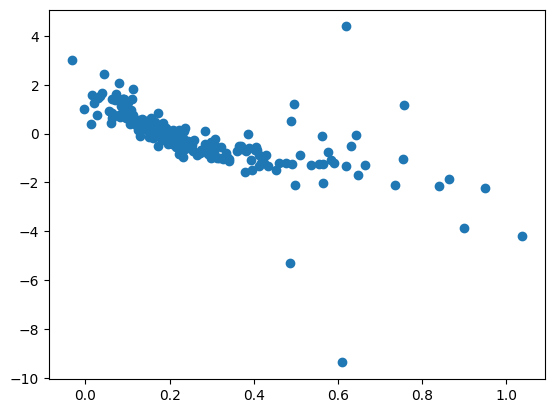

In [225]:
df_sbux_atm_put_vol_actual_change = df_sbux_atm_vol_history[['atm_put_vol_market_open']].join(df_sbux_market_open_close_history[['actual_change']])
plt.scatter(df_sbux_atm_put_vol_actual_change[["atm_put_vol_market_open"]], df_sbux_atm_put_vol_actual_change[["actual_change"]])
#plt.plot([-1, 1], [-1, 1], 'k-', color = 'r')

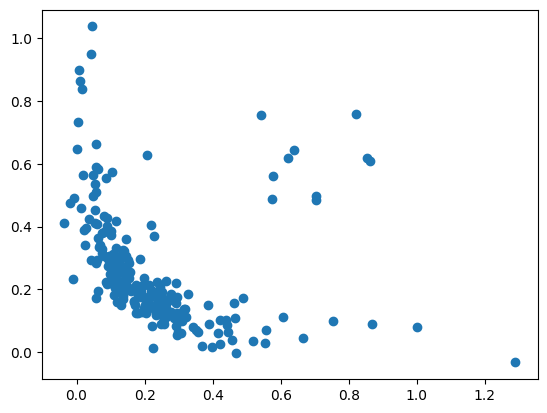

In [226]:
plt.scatter(df_sbux_atm_vol_history[["atm_call_vol_market_open"]], df_sbux_atm_vol_history[["atm_put_vol_market_open"]])

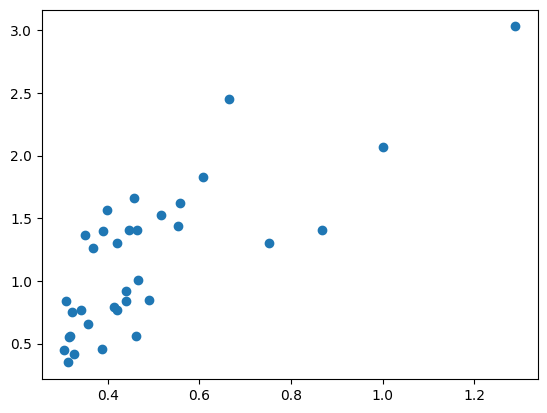

In [891]:
_market_openlarge_vol_threshold = 0.3
df_sbux_large_atm_call_vol_history = df_sbux_atm_vol_history[
    (df_sbux_atm_vol_history.atm_call_vol_market_open > large_vol_threshold) &
    (df_sbux_atm_vol_history.atm_put_vol_market_open < large_vol_threshold)
]
df_sbux_large_atm_call_vol_atm_actual_change = df_sbux_large_atm_call_vol_history[['atm_call_vol_market_open']].join(df_sbux_market_open_close_history[['actual_change']])
plt.scatter(df_sbux_large_atm_call_vol_atm_actual_change[["atm_call_vol_market_open"]], df_sbux_large_atm_call_vol_atm_actual_change[["actual_change"]])

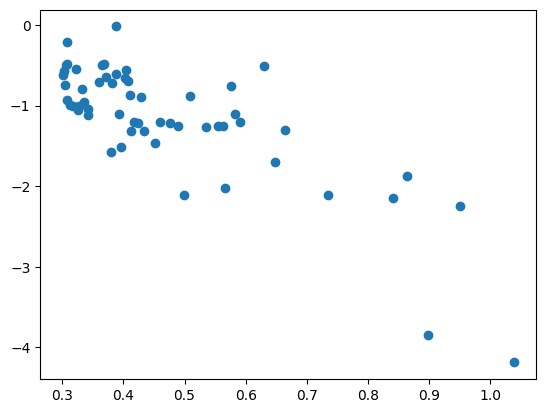

In [895]:
large_vol_threshold = 0.3
df_sbux_large_atm_put_vol_history = df_sbux_atm_vol_history[
    (df_sbux_atm_vol_history.atm_call_vol_market_open < large_vol_threshold) &
    (df_sbux_atm_vol_history.atm_put_vol_market_open > large_vol_threshold)
]
df_sbux_large_atm_put_vol_atm_actual_change = df_sbux_large_atm_put_vol_history[['atm_put_vol_market_open']].join(df_sbux_market_open_close_history[['actual_change']])
plt.scatter(df_sbux_large_atm_put_vol_atm_actual_change[["atm_put_vol_market_open"]], df_sbux_large_atm_put_vol_atm_actual_change[["actual_change"]])

/var/folders/hh/x43xkncs2k7dm7t4vg3lt2cm0000gn/T/ipykernel_96764/870103466.py:13: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot([-1, 1], [-1, 1], 'k-', color = 'r')


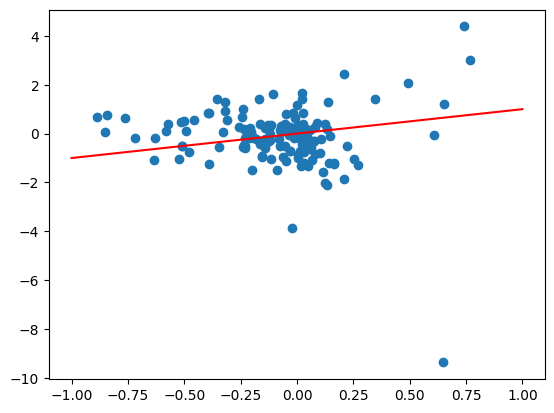

In [869]:
rolling_size = 90
df_sbux_atm_vol_history['atm_vol'] = (df_sbux_atm_vol_history.atm_call_vol + df_sbux_atm_vol_history.atm_put_vol) / 2.0
df_sbux_atm_vol_min_max_history = df_sbux_atm_vol_history.join(df_sbux_atm_vol_history[['atm_vol']].rolling(rolling_size).min().join(df_sbux_atm_vol_history[['atm_vol']].rolling(rolling_size).max(), lsuffix="_min", rsuffix="_max"))
df_sbux_atm_vol_min_max_history['atm_vol_level'] = (df_sbux_atm_vol_min_max_history.atm_vol - df_sbux_atm_vol_min_max_history.atm_vol_min) / (df_sbux_atm_vol_min_max_history.atm_vol_max - df_sbux_atm_vol_min_max_history.atm_vol_min)
df_vix1d_market_open_min_max_history = df_vix1d_market_open_history.join(df_vix1d_market_open_history.rolling(rolling_size).min().join(df_vix1d_market_open_history.rolling(rolling_size).max(), lsuffix="_min", rsuffix="_max"))
df_vix1d_market_open_min_max_history['vix_level'] = (df_vix1d_market_open_min_max_history.c - df_vix1d_market_open_min_max_history.c_min) / (df_vix1d_market_open_min_max_history.c_max - df_vix1d_market_open_min_max_history.c_min)

df_vix1d_sbux_vol_min_max_history = df_sbux_atm_vol_min_max_history[['atm_vol_level']].join(df_vix1d_market_open_min_max_history[['vix_level']])
df_vix1d_sbux_vol_min_max_history['atm_minus_vix_level'] = df_vix1d_sbux_vol_min_max_history.atm_vol_level - df_vix1d_sbux_vol_min_max_history.vix_level
df_vix1d_sbux_vol_min_max_actual_history = df_vix1d_sbux_vol_min_max_history.join(df_sbux_market_open_close_history["actual_change"])

plt.scatter(df_vix1d_sbux_vol_min_max_actual_history[["atm_minus_vix_level"]], df_vix1d_sbux_vol_min_max_actual_history[["actual_change"]])
plt.plot([-1, 1], [-1, 1], 'k-', color = 'r')

## sbux logic

In [798]:
df_sbux = df_sbux_daily_history[["c"]].copy()
df_sbux["1_mo_avg"] = df_sbux["c"].rolling(window=20).mean()
df_sbux["3_mo_avg"] = df_sbux["c"].rolling(window=60).mean()
df_sbux['regime'] = df_sbux.apply(lambda row: 1 if (row['c'] > row['1_mo_avg']) else -1, axis=1)

In [799]:
df_sbux_market_close_history = get_df_market_open_or_close_history_from_intraday_history(df_sbux_intraday_history, "close")
df_sbux_market_open_close_history = df_sbux_market_open_history.join(df_sbux_market_close_history, lsuffix="_open", rsuffix="_close")
df_sbux_market_open_close_history["actual_change"] = df_sbux_market_open_close_history.c_close - df_sbux_market_open_close_history.c_open

In [1254]:
df_sbux_daily_expectation = algo.expectation.get_df_daily_expectation(
    df_sbux_market_open_history, df_sbux.regime, 
    (df_sbux_atm_vol_history.atm_call_vol + df_sbux_atm_vol_history.atm_put_vol) / 2, 
    1.0)

In [1255]:
df_sbux_daily_expectation

,c_market_open,regime,expected_move,lower_price,upper_price
t,,,,,
2023-05-02,113.3832,1,0.0374,109.14,117.62
2023-05-03,107.6863,-1,0.0341,104.01,111.36
2023-05-04,104.3100,-1,0.0162,102.62,106.00
2023-05-05,105.4826,-1,NaN,NaN,NaN
2023-05-08,108.0200,-1,0.0123,106.69,109.35
...,...,...,...,...,...
2024-06-26,79.0200,-1,0.0133,77.97,80.07
2024-06-27,78.8800,-1,0.0141,77.77,79.99
2024-06-28,78.5997,-1,NaN,NaN,NaN


In [1256]:
df_sbux_daily_expectation_actual = df_sbux_daily_expectation.join(df_sbux_market_open_close_history["actual_change"])
df_sbux_daily_expectation_actual["expected_change_size"] = (df_sbux_daily_expectation_actual.upper_price - df_sbux_daily_expectation_actual.lower_price) / 2.

/var/folders/hh/x43xkncs2k7dm7t4vg3lt2cm0000gn/T/ipykernel_96764/25140229.py:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot([-1, 6], [-1, 6], 'k-', color = 'r')


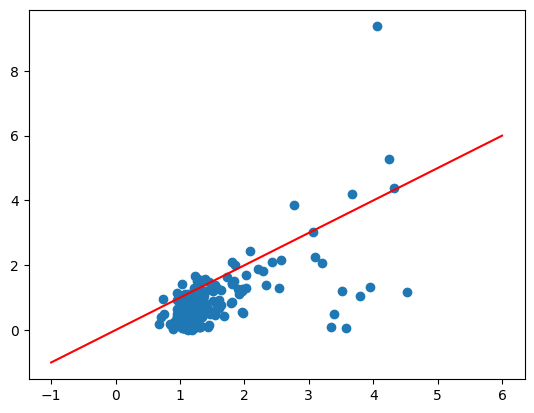

In [1257]:
plt.scatter(df_sbux_daily_expectation_actual[["expected_change_size"]], df_sbux_daily_expectation_actual[["actual_change"]].abs())
plt.plot([-1, 6], [-1, 6], 'k-', color = 'r')

/var/folders/hh/x43xkncs2k7dm7t4vg3lt2cm0000gn/T/ipykernel_96764/2474148535.py:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot([-10, 10], [-10, 10], 'k-', color = 'r')


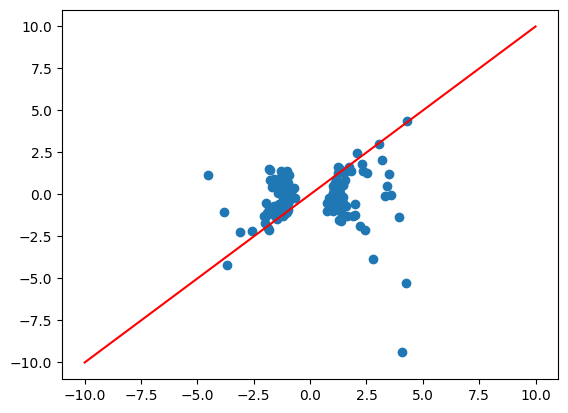

In [1258]:
plt.scatter(df_sbux_daily_expectation_actual["regime"] * df_sbux_daily_expectation_actual["expected_change_size"], df_sbux_daily_expectation_actual[["actual_change"]])
plt.plot([-10, 10], [-10, 10], 'k-', color = 'r')

## logic with options data

In [724]:
df_spx_algo = df_spx_daily_expectation.join(df_spx_otm_call_options_spread_history[["pnl", "pnl_midday", "pnl_market_close"]].add_suffix("_call")).join(
    df_spx_otm_put_options_spread_history[["pnl", "pnl_midday", "pnl_market_close"]].add_suffix("_put")
)
df_spx_algo['pnl_c_n_reg'] = np.where(df_spx_algo.regime < 0, df_spx_algo.pnl_call, 0)
df_spx_algo['pnl_p_p_reg'] = np.where(df_spx_algo.regime > 0, df_spx_algo.pnl_put, 0)

In [725]:
df_spx_algo

,c_open,regime,expected_move,lower_price,upper_price,pnl_call,pnl_midday_call,pnl_market_close_call,pnl_put,pnl_midday_put,pnl_market_close_put,pnl_c_n_reg,pnl_p_p_reg
t,,,,,,,,,,,,,
2023-05-01,4168.46,1,0.0029,4156.37,4180.55,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN
2023-05-02,4153.26,-1,0.0030,4140.80,4165.72,0.80,0.75,0.80,-4.40,-4.500000e+00,-4.40,0.80,0.00
2023-05-03,4125.70,-1,0.0060,4100.95,4150.45,1.15,-0.50,1.15,-3.50,8.881784e-16,-3.50,1.15,0.00
2023-05-04,4081.20,-1,0.0047,4062.02,4100.38,0.95,0.80,0.95,-0.35,-7.000000e-01,-0.35,0.95,0.00
2023-05-05,4104.23,1,0.0041,4087.40,4121.06,-4.50,-1.10,-4.50,0.75,6.000000e-01,0.75,0.00,0.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-26,5457.73,1,0.0024,5444.63,5470.83,-1.75,-0.70,-1.75,0.80,6.500000e-01,0.80,0.00,0.80
2024-06-27,5483.08,1,0.0024,5469.92,5496.24,0.75,0.40,0.75,0.50,-1.000000e-01,0.50,0.00,0.50
2024-06-28,5496.61,1,0.0028,5481.22,5512.00,1.05,0.75,1.05,-4.60,-7.000000e-01,-4.60,0.00,-4.60


array([[<Axes: title={'center': 'pnl_c_n_reg'}>]], dtype=object)

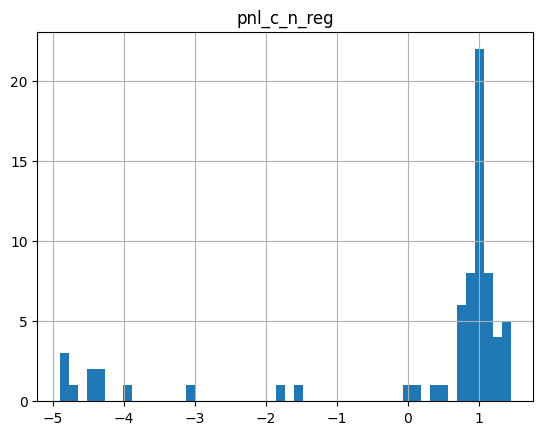

In [726]:
df_spx_algo[df_spx_algo.regime < 0][["pnl_c_n_reg"]].hist(bins=50)

array([[<Axes: title={'center': 'pnl_p_p_reg'}>]], dtype=object)

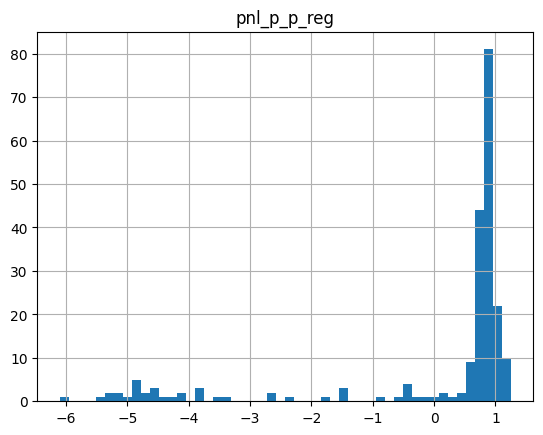

In [727]:
df_spx_algo[df_spx_algo.regime > 0][["pnl_p_p_reg"]].hist(bins=50)

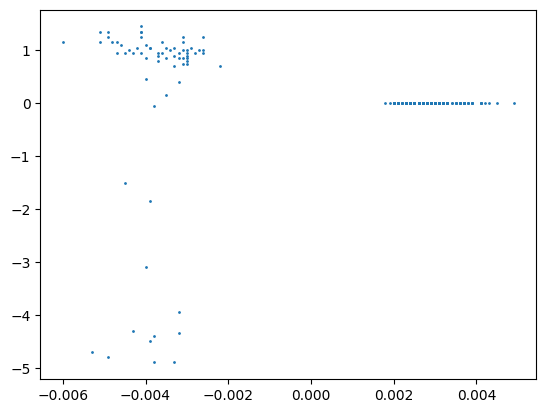

In [728]:
plt.scatter(df_spx_algo["expected_move"] * df_spx_algo["regime"], df_spx_algo[["pnl_c_n_reg"]], s=1)

<Axes: xlabel='t'>

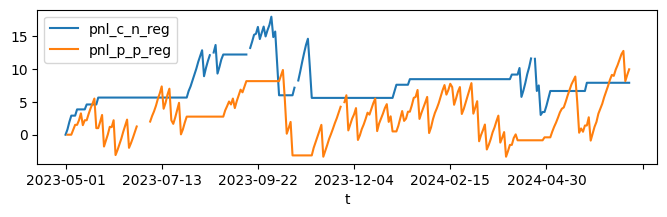

In [729]:
df_spx_algo[["pnl_c_n_reg", "pnl_p_p_reg"]].cumsum().plot(figsize=(8,2))

<Axes: xlabel='t'>

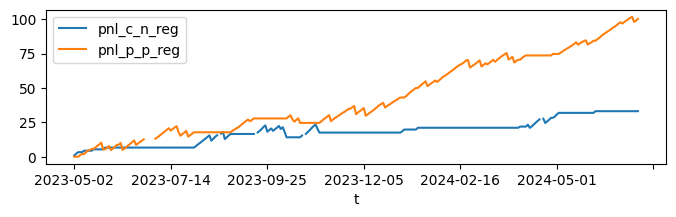

In [603]:
# below is the result ignoring the quote spread (unrealistic)
df_spx_algo[["pnl_c_n_reg", "pnl_p_p_reg"]].cumsum().plot(figsize=(8,2))

In [720]:
df_spx_algo.groupby("regime")[["pnl_market_close_call", "pnl_market_close_put"]].sum()

,pnl_market_close_call,pnl_market_close_put
regime,,
-1,7.90,-108.55
1,-108.95,9.95


In [507]:
df_spx_algo.groupby("regime")[["pnl_call", "pnl_put"]].sum()

,pnl_call,pnl_put
regime,,
-1,33.14,-74.90
1,-54.36,100.26


In [508]:
df_spx_otm_call_options_spread_history[
    df_spx_algo["regime"] < 0
].sum()

/tmp/ipykernel_51020/2214457600.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_spx_otm_call_options_spread_history[


c_market_o_s_call    323.67
c_market_o_l_call    239.52
market_o_spread       84.15
c_market_c_s_call    196.58
c_market_c_l_call    145.57
market_c_spread       51.01
pnl                   33.14
dtype: float64

In [509]:
df_spx_otm_call_options_spread_history.sum()

c_market_o_s_call    1047.16
c_market_o_l_call     732.10
market_o_spread       315.06
c_market_c_s_call    1132.63
c_market_c_l_call     796.35
market_c_spread       336.28
pnl                   -21.22
dtype: float64

In [510]:
df_spx_otm_put_options_spread_history[
    df_spx_algo["regime"] > 0
].sum()

/tmp/ipykernel_51020/465159656.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_spx_otm_put_options_spread_history[


c_market_o_s_put    896.91
c_market_o_l_put    668.93
market_o_spread     227.98
c_market_c_s_put    478.88
c_market_c_l_put    351.16
market_c_spread     127.72
pnl                 100.26
dtype: float64

In [511]:
df_spx_otm_put_options_spread_history.sum()

c_market_o_s_put    1306.32
c_market_o_l_put     997.03
market_o_spread      309.29
c_market_c_s_put    1205.80
c_market_c_l_put     921.87
market_c_spread      283.93
pnl                   25.36
dtype: float64

## goog logic with options data

In [1266]:
df_goog_algo = df_goog_daily_expectation.join(df_goog_otm_call_options_spread_history[["pnl"]].add_suffix("_call")).join(
    df_goog_otm_put_options_spread_history[["pnl"]].add_suffix("_put")
)
df_goog_algo['pnl_c'] = df_goog_algo.pnl_call
df_goog_algo['pnl_p'] = df_goog_algo.pnl_put
df_goog_algo['pnl_c_n_reg'] = np.where(df_goog_algo.regime < 0, df_goog_algo.pnl_call, 0)
df_goog_algo['pnl_p_p_reg'] = np.where(df_goog_algo.regime > 0, df_goog_algo.pnl_put, 0)

<AxesSubplot:xlabel='t'>

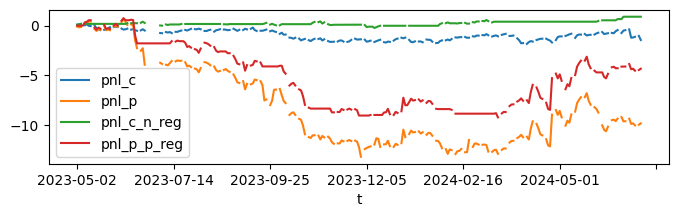

In [1267]:
df_goog_algo[["pnl_c", "pnl_p", "pnl_c_n_reg", "pnl_p_p_reg"]].cumsum().plot(figsize=(8,2))

<AxesSubplot:xlabel='t'>

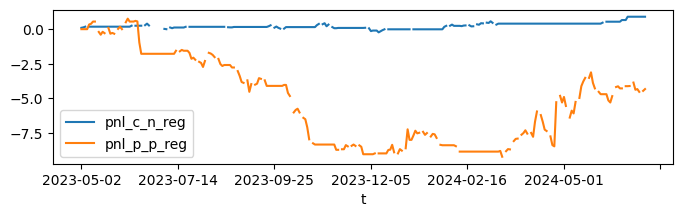

In [1268]:
df_goog_algo[["pnl_c_n_reg", "pnl_p_p_reg"]].cumsum().plot(figsize=(8,2))

<AxesSubplot:xlabel='t'>

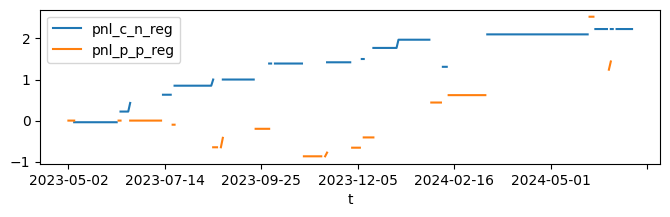

In [795]:
df_goog_algo[["pnl_c_n_reg", "pnl_p_p_reg"]].cumsum().plot(figsize=(8,2))

In [78]:
df_goog_algo.groupby("regime")[["pnl_call", "pnl_put"]].sum()

,pnl_call,pnl_put
regime,,
-1,1.56,-4.85
1,-1.72,-3.05


In [796]:
df_goog_algo.groupby("regime")[["pnl_call", "pnl_put"]].sum()

,pnl_call,pnl_put
regime,,
-1,2.23,2.45
1,2.73,1.80


## sbux logic with options data

In [396]:
df_sbux_algo = df_sbux_daily_expectation.join(df_sbux_otm_call_options_spread_history[["pnl"]].add_suffix("_call")).join(
    df_sbux_otm_put_options_spread_history[["pnl"]].add_suffix("_put")
)
df_sbux_algo['pnl_c_n_reg'] = np.where(df_sbux_algo.regime < 0, df_sbux_algo.pnl_call, 0)
df_sbux_algo['pnl_p_p_reg'] = np.where(df_sbux_algo.regime > 0, df_sbux_algo.pnl_put, 0)

<AxesSubplot:xlabel='t'>

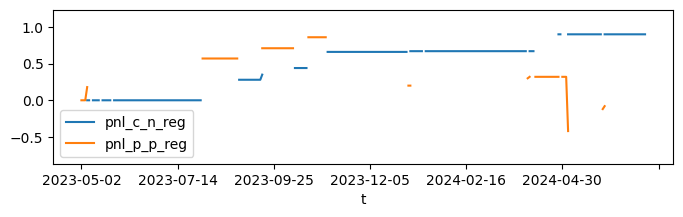

In [397]:
df_sbux_algo[["pnl_c_n_reg", "pnl_p_p_reg"]].cumsum().plot(figsize=(8,2))

In [264]:
df_sbux_algo.groupby("regime")[["pnl_call", "pnl_put"]].sum()

,pnl_call,pnl_put
regime,,
-1,0.90,-0.54
1,-0.14,-0.66


## volatility calc

In [128]:
df_goog_atm_vol_history["expected_move"] = ((df_goog_atm_vol_history.atm_call_vol + df_goog_atm_vol_history.atm_put_vol) / 2 / np.sqrt(252))

In [149]:
df_sbux_atm_vol_history["expected_move"] = ((df_sbux_atm_vol_history.atm_call_vol + df_sbux_atm_vol_history.atm_put_vol) / 2 / np.sqrt(252))

In [732]:
(df_goog_atm_vol_history.atm_call_vol + df_goog_atm_vol_history.atm_put_vol) / 2

date
2023-05-02    0.297181
2023-05-03    0.261481
2023-05-04    0.262665
2023-05-08    0.319597
2023-05-09    0.359917
                ...   
2024-06-25    0.256182
2024-06-26    0.178506
2024-06-27    0.180017
2024-07-01    0.145797
2024-07-02    0.286338
Length: 229, dtype: float64

## debug

In [328]:
ticker = "GOOG"
date = "2024-06-11"
quote_timestamp = (pd.to_datetime(date).tz_localize("America/New_York") + timedelta(hours = 15, minutes = 55)).value
close_timestamp = (pd.to_datetime(date).tz_localize("America/New_York") + timedelta(hours = 16, minutes = 0)).value

In [347]:
price = df_goog_market_open_history.loc[date].c

In [423]:
calls = pd.json_normalize(requests.get(f"https://api.polygon.io/v3/reference/options/contracts?underlying_ticker={ticker}&contract_type=call&as_of={date}&limit=1000&apiKey={polygon_api_key}").json()["results"])

In [424]:
calls["days_to_exp"] = (pd.to_datetime(calls["expiration_date"]) - pd.to_datetime(date)).dt.days
#calls = calls[calls["days_to_exp"] >= 5].copy()
nearest_exp_date = calls["expiration_date"].iloc[0]
calls = calls[calls["expiration_date"] == nearest_exp_date].copy()

In [425]:
nearest_exp_date

'2024-06-14'

In [426]:
calls["distance_from_price"] = abs(round(((calls["strike_price"] - price) / price)*100, 2))

In [444]:
calls.head()

,cfi,contract_type,exercise_style,expiration_date,primary_exchange,shares_per_contract,strike_price,ticker,underlying_ticker,days_to_exp,distance_from_price
0,OCASPS,call,american,2024-06-14,BATO,100,85.0,O:GOOG240614C00085000,GOOG,3,52.15
1,OCASPS,call,american,2024-06-14,BATO,100,90.0,O:GOOG240614C00090000,GOOG,3,49.34
2,OCASPS,call,american,2024-06-14,BATO,100,95.0,O:GOOG240614C00095000,GOOG,3,46.52
3,OCASPS,call,american,2024-06-14,BATO,100,100.0,O:GOOG240614C00100000,GOOG,3,43.71
4,OCASPS,call,american,2024-06-14,BATO,100,105.0,O:GOOG240614C00105000,GOOG,3,40.89


In [428]:
atm_call = calls.nsmallest(1, "distance_from_price")

In [429]:
atm_call

,cfi,contract_type,exercise_style,expiration_date,primary_exchange,shares_per_contract,strike_price,ticker,underlying_ticker,days_to_exp,distance_from_price
27,OCASPS,call,american,2024-06-14,BATO,100,177.5,O:GOOG240614C00177500,GOOG,3,0.08


In [430]:
call_quotes = pd.json_normalize(requests.get(f"https://api.polygon.io/v3/quotes/{atm_call['ticker'].iloc[0]}?timestamp.gte={quote_timestamp}&timestamp.lt={close_timestamp}&order=desc&limit=100&sort=timestamp&apiKey={polygon_api_key}").json()["results"]).set_index("sip_timestamp")
call_quotes.index = pd.to_datetime(call_quotes.index, unit = "ns", utc = True).tz_convert("America/New_York")
call_quotes["mid_price"] = round((call_quotes["bid_price"] + call_quotes["ask_price"]) / 2, 2)

In [432]:
time_to_expiration = atm_call.days_to_exp.values[0] / 252

In [433]:
atm_call_vol = call_implied_vol(S=price, K=atm_call["strike_price"].iloc[0], t=time_to_expiration, r=.045, option_price=call_quotes["mid_price"].iloc[0])

In [434]:
atm_call_vol

0.240868986287512

In [ ]:
puts = pd.json_normalize(requests.get(f"https://api.polygon.io/v3/reference/options/contracts?underlying_ticker={ticker}&contract_type=put&as_of={date}&limit=1000&apiKey={polygon_api_key}").json()["results"])
puts["days_to_exp"] = (pd.to_datetime(puts["expiration_date"]) - pd.to_datetime(date)).dt.days
puts = puts[puts["expiration_date"] == nearest_exp_date].copy()
puts["distance_from_price"] = abs(round(((price - puts["strike_price"]) / puts["strike_price"])*100, 2))
atm_put = puts.nsmallest(1, "distance_from_price")

In [435]:
puts = pd.json_normalize(requests.get(f"https://api.polygon.io/v3/reference/options/contracts?underlying_ticker={ticker}&contract_type=put&as_of={date}&limit=1000&apiKey={polygon_api_key}").json()["results"])

In [436]:
puts["days_to_exp"] = (pd.to_datetime(puts["expiration_date"]) - pd.to_datetime(date)).dt.days
puts = puts[puts["expiration_date"] == nearest_exp_date].copy()

In [437]:
puts["distance_from_price"] = abs(round(((price - puts["strike_price"]) / puts["strike_price"])*100, 2))

In [438]:
atm_put = puts.nsmallest(1, "distance_from_price")

In [439]:
atm_put

,cfi,contract_type,exercise_style,expiration_date,primary_exchange,shares_per_contract,strike_price,ticker,underlying_ticker,days_to_exp,distance_from_price
27,OPASPS,put,american,2024-06-14,BATO,100,177.5,O:GOOG240614P00177500,GOOG,3,0.08


In [440]:
put_quotes = pd.json_normalize(requests.get(f"https://api.polygon.io/v3/quotes/{atm_put['ticker'].iloc[0]}?timestamp.gte={quote_timestamp}&timestamp.lt={close_timestamp}&order=desc&limit=100&sort=timestamp&apiKey={polygon_api_key}").json()["results"]).set_index("sip_timestamp")
put_quotes.index = pd.to_datetime(put_quotes.index, unit = "ns", utc = True).tz_convert("America/New_York")
put_quotes["mid_price"] = round((put_quotes["bid_price"] + put_quotes["ask_price"]) / 2, 2)

In [441]:
atm_put_vol = put_implied_vol(S=price, K=atm_put["strike_price"].iloc[0], t=time_to_expiration, r=.045, option_price=put_quotes["mid_price"].iloc[0])

In [442]:
atm_put_vol

0.1921287338318709

In [443]:
atm_vol = round(((atm_call_vol + atm_put_vol) / 2)*100, 2)
expected_move = (round((atm_vol / np.sqrt(252)), 2))

In [ ]:

end_time = datetime.now()
seconds_to_complete = (end_time - start_time).total_seconds()
times.append(seconds_to_complete)
iteration = round((np.where(trading_dates==date)[0][0]/len(trading_dates))*100,2)
iterations_remaining = len(trading_dates) - np.where(trading_dates==date)[0][0]
average_time_to_complete = np.mean(times)
estimated_completion_time = (datetime.now() + timedelta(seconds = int(average_time_to_complete*iterations_remaining)))
time_remaining = estimated_completion_time - datetime.now()
print(f"{iteration}% complete, {time_remaining} left, ETA: {estimated_completion_time}")
